In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ZeroMean
from gpytorch.kernels import  MaternKernel

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 20,
})

In [3]:
# Create the Gaussian Process model following the example: https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html

class MyGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, mean_function, kernel):
        super(MyGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean_function
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def train_GPR(x_train, y_train,kernel, mean_function, likelihood, epochs):
    l=[]

    model = MyGPModel(x_train, y_train, likelihood, mean_function, kernel)

    # Training the model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Use Adam optimizer

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # Training loop
    for i in range(epochs):

        optimizer.zero_grad()
        output = model(x_train)
        loss = -mll(output, y_train)
        l+= [loss.item()]

        loss.backward()
        optimizer.step()

        print('\n******* Iteration {} *******'.format(i+1))

        for param_name, param in model.named_parameters():
            print(f'Parameter name: {param_name:42} value = {param.item()}')

        print(f'Epoch {i+1}/{epochs}, Loss: {loss.item()}')
        
    return model, l

def make_predictions(model, test_x, likelihood):
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
        # var = observed_pred.variance # Get the variance from the predictive distribution and set the bounds manually
        lower, upper = observed_pred.confidence_region() # Get the bounds from the predictive distribution
        return observed_pred, lower, upper

def plot_predictions(x_train, y_train,test_x, observed_pred, lower, upper):
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 6))
    # Plot training data as black stars
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    # ax.fill_between(test_x.numpy(), observed_pred.mean.numpy()-1.96*np.sqrt(lower.numpy()), observed_pred.mean.numpy()+1.96*np.sqrt(upper.numpy()), alpha=0.5) # with manual variance
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [4]:
x_train = np.array([-4.3, -4.6, -4.8, -3.1, -1.4, -5.6, -6.8, -4.1, -0.5, -2.4, -4.9, -3.6, -8.2, -5.9, -4.0,
                    -8.5, -8.6, -0.6, -7.0, -7.4, -2.6, -2.9, -9.7, -2.2, -8.1, -1.9, -5.3, -6.7, -8.0, -0.4,
                    -3.5, -5.8, -2.3, -1.5, -9.8, 10.0, 10.2, 10.1, 10.6, 9.5, -6.8, -7.0, -6.8, -6.9, -6.8]
                   ).reshape((-1, 1))
y_train = np.array([-0.6, 0.0, 0.2, -1.8, -1.7, 1.3, 1.8, -0.6, -0.6, -2.2, 0.3, -1.2, 1.5, 1.5, -1.1, 1.1, 1.4,
                    -0.7, 2.1, 1.8, -1.8, -1.9, -0.1, -2.1, 1.6, -1.9, 0.5, 1.5, 1.3, -0.7, -1.3, 1.6, -2.2, -1.6,
                    -0.3, 0.7, 1.1, 0.9, 1.0, 0.6, 2.0, 1.9, 1.9, 2.1, 1.9]).reshape((-1,1))

X = torch.from_numpy(x_train).double()
Y = torch.from_numpy(y_train).double().squeeze(-1)

X_t = torch.linspace(float(min(X).item()-5), float(max(X).item()+5), 100, dtype=torch.float64).unsqueeze(-1)


******* Iteration 1 *******
Parameter name: likelihood.noise_covar.raw_noise           value = -0.09999998658895493
Parameter name: covar_module.raw_lengthscale               value = 0.09999998658895493
Epoch 1/200, Loss: 1.1539543498206752

******* Iteration 2 *******
Parameter name: likelihood.noise_covar.raw_noise           value = -0.20006227493286133
Parameter name: covar_module.raw_lengthscale               value = 0.19991907477378845
Epoch 2/200, Loss: 1.1179249719354991

******* Iteration 3 *******
Parameter name: likelihood.noise_covar.raw_noise           value = -0.3002226948738098
Parameter name: covar_module.raw_lengthscale               value = 0.29968804121017456
Epoch 3/200, Loss: 1.0815727440142568

******* Iteration 4 *******
Parameter name: likelihood.noise_covar.raw_noise           value = -0.4005124270915985
Parameter name: covar_module.raw_lengthscale               value = 0.3992275595664978
Epoch 4/200, Loss: 1.0449579547370649

******* Iteration 5 *******
Parame

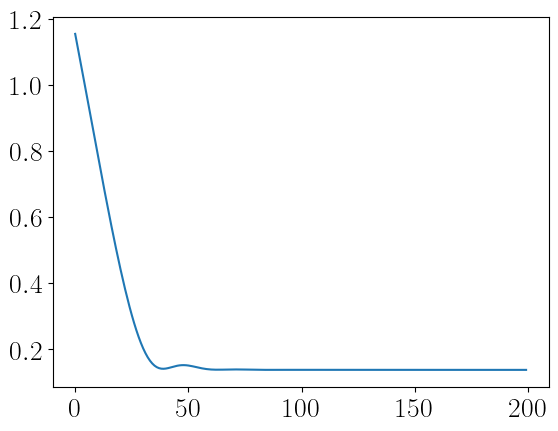

In [5]:
likelihood = GaussianLikelihood()
mean_function = ZeroMean()
kernel = MaternKernel(nu=1.5)

num_iter = 200

model, l = train_GPR(X,Y,kernel, mean_function, likelihood, num_iter)

plt.plot(l)
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

observed_pred, lower, upper = make_predictions(model, X_t, likelihood)

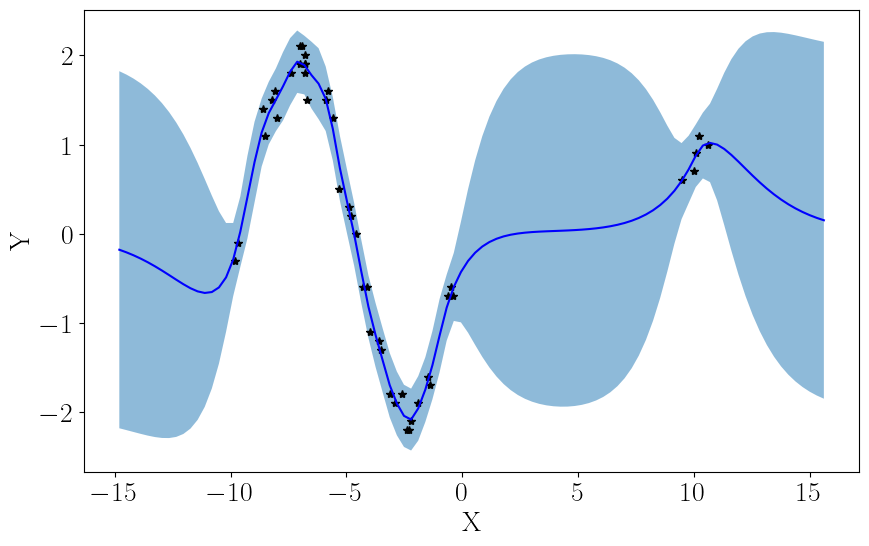

Kernel parameters: lenghtscale = Parameter containing:
tensor([[2.4240]], requires_grad=True), noise_var= Parameter containing:
tensor([-3.7276], requires_grad=True), exp_noise_var= tensor([0.0241], grad_fn=<ExpBackward0>)


In [6]:
plot_predictions(X,Y,X_t.squeeze(-1), observed_pred, lower, upper)
# get model parameters and print them
print(f"Kernel parameters: lenghtscale = {model.covar_module.raw_lengthscale}, noise_var= {model.likelihood.noise_covar.raw_noise}, exp_noise_var= {torch.exp(model.likelihood.noise_covar.raw_noise)}")

In [7]:
library_mu = observed_pred.mean.numpy()
library_mu

array([-0.17927102, -0.208506  , -0.24155167, -0.27857755, -0.31962077,
       -0.36451402, -0.41278699, -0.46353258, -0.51522684, -0.56548822,
       -0.61075752, -0.64587458, -0.66352053, -0.65348618, -0.60171494,
       -0.48905522, -0.28963789,  0.02286216,  0.40982894,  0.80294822,
        1.13384121,  1.35269544,  1.50126446,  1.65207057,  1.8159668 ,
        1.92794516,  1.89032464,  1.77780902,  1.68198164,  1.51276706,
        1.17541973,  0.73226734,  0.35937272, -0.00760735, -0.42308443,
       -0.81605803, -1.1332356 , -1.41796143, -1.69761907, -1.90187632,
       -2.04109337, -2.0826235 , -1.95757836, -1.74655762, -1.47193247,
       -1.14241579, -0.82779058, -0.59568979, -0.42959025, -0.30506511,
       -0.21225835, -0.14355476, -0.09308174, -0.05631929, -0.02979492,
       -0.01084522,  0.00257053,  0.01201581,  0.0186907 ,  0.02352089,
        0.02722762,  0.0303829 ,  0.03345359,  0.03683712,  0.04089105,
        0.04595847,  0.0523907 ,  0.0605687 ,  0.07092428,  0.08

In [8]:
manual_mu = np.load("manual_mu.npy")
manual_mu

array([-0.17927338, -0.20850852, -0.24155432, -0.27858031, -0.31962358,
       -0.36451682, -0.41278971, -0.46353512, -0.51522909, -0.56549006,
       -0.61075884, -0.64587525, -0.66352048, -0.65348538, -0.60171352,
       -0.48905346, -0.28963642,  0.02286245,  0.40982785,  0.8029462 ,
        1.13383932,  1.35269485,  1.50126534,  1.65207193,  1.81596696,
        1.92794401,  1.89032475,  1.77781077,  1.68198215,  1.51276593,
        1.17541933,  0.73226906,  0.35937339, -0.00760798, -0.42308446,
       -0.81605742, -1.13323555, -1.41796187, -1.69761896, -1.90187649,
       -2.0410933 , -2.08262267, -1.9575782 , -1.74655753, -1.47193221,
       -1.14241618, -0.82779142, -0.59568985, -0.42958934, -0.30506351,
       -0.21225628, -0.1435524 , -0.09307922, -0.05631672, -0.02979237,
       -0.01084275,  0.00257288,  0.01201802,  0.01869276,  0.0235228 ,
        0.02722936,  0.03038449,  0.03345505,  0.03683844,  0.04089225,
        0.04595957,  0.05239172,  0.06056963,  0.07092515,  0.08

In [9]:
library_mu-manual_mu

array([ 2.36393142e-06,  2.52010928e-06,  2.65376336e-06,  2.75393787e-06,
        2.80774002e-06,  2.80050388e-06,  2.71625028e-06,  2.53859914e-06,
        2.25235478e-06,  1.84607097e-06,  1.31601917e-06,  6.72140694e-07,
       -5.32263171e-08, -7.92773453e-07, -1.42635728e-06, -1.75590279e-06,
       -1.47048075e-06, -2.85795161e-07,  1.09151199e-06,  2.02549717e-06,
        1.89143207e-06,  5.87213441e-07, -8.83658755e-07, -1.35560743e-06,
       -1.63176036e-07,  1.15312828e-06, -1.17373280e-07, -1.75272353e-06,
       -5.16785539e-07,  1.12344221e-06,  3.97931573e-07, -1.71235968e-06,
       -6.72627722e-07,  6.29829168e-07,  3.19219495e-08, -6.09956858e-07,
       -4.26533990e-08,  4.46440915e-07, -1.10262559e-07,  1.63591943e-07,
       -7.34954790e-08, -8.38368354e-07, -1.61264727e-07, -9.10044919e-08,
       -2.62047639e-07,  3.87040707e-07,  8.38771067e-07,  5.72812866e-08,
       -9.06407259e-07, -1.59769051e-06, -2.06810150e-06, -2.36283017e-06,
       -2.52062878e-06, -

In [10]:
observed_pred.variance.numpy()

array([1.0008851 , 0.99216523, 0.98037383, 0.9645558 , 0.9435284 ,
       0.91586747, 0.8799214 , 0.83387522, 0.77589657, 0.7044066 ,
       0.61852724, 0.51875517, 0.40788484, 0.29211442, 0.18205487,
       0.09290179, 0.04210098, 0.03904904, 0.05350072, 0.0511221 ,
       0.0362495 , 0.03073563, 0.03092327, 0.03672098, 0.03548046,
       0.03055509, 0.02700916, 0.03507325, 0.03949104, 0.03261216,
       0.03154504, 0.03318335, 0.03201218, 0.03089137, 0.03132022,
       0.03076508, 0.032127  , 0.03218465, 0.03253125, 0.03188893,
       0.03035366, 0.03008672, 0.03267838, 0.03291708, 0.0365595 ,
       0.0420546 , 0.03428028, 0.03642411, 0.07936569, 0.16141654,
       0.26737011, 0.38198302, 0.4938387 , 0.59584314, 0.68446017,
       0.75865591, 0.81894706, 0.86667368, 0.90349742, 0.93108257,
       0.95090959, 0.96417608, 0.97175086, 0.9741566 , 0.97156552,
       0.96379926, 0.9503306 , 0.93028977, 0.90248451, 0.86544982,
       0.81755218, 0.75718253, 0.6830822 , 0.59484985, 0.49366

In [11]:
manual_var = np.load("manual_var.npy")
manual_var

array([1.00088503, 0.99216499, 0.9803734 , 0.96455513, 0.94352746,
       0.91586623, 0.87991986, 0.83387339, 0.77589448, 0.70440435,
       0.61852496, 0.51875306, 0.40788312, 0.29211332, 0.18205453,
       0.09290218, 0.04210176, 0.03904972, 0.05350117, 0.05112261,
       0.03625018, 0.03073627, 0.03092393, 0.0367216 , 0.03548111,
       0.0305557 , 0.02700977, 0.0350738 , 0.03949159, 0.03261282,
       0.03154569, 0.03318399, 0.03201282, 0.03089201, 0.03132085,
       0.03076572, 0.03212764, 0.0321853 , 0.0325319 , 0.03188957,
       0.03035429, 0.03008735, 0.03267901, 0.03291775, 0.03656017,
       0.04205515, 0.03428092, 0.03642483, 0.07936616, 0.16141641,
       0.26736928, 0.38198155, 0.49383679, 0.59584099, 0.68445798,
       0.75865382, 0.81894516, 0.86667203, 0.90349602, 0.9310814 ,
       0.95090862, 0.96417526, 0.97175012, 0.9741559 , 0.9715648 ,
       0.96379846, 0.95032967, 0.93028866, 0.90248318, 0.86544828,
       0.81755044, 0.75718064, 0.68308027, 0.59484802, 0.49366

In [12]:
observed_pred.variance.numpy()-manual_var

array([ 7.09737829e-08,  2.38117791e-07,  4.38839166e-07,  6.74269075e-07,
        9.42417162e-07,  1.23646615e-06,  1.54274239e-06,  1.83860444e-06,
        2.09078423e-06,  2.25516061e-06,  2.27954835e-06,  2.11175169e-06,
        1.71553197e-06,  1.09641231e-06,  3.35435338e-07, -3.82042381e-07,
       -7.82065021e-07, -6.81438556e-07, -4.51519707e-07, -5.15127808e-07,
       -6.87492331e-07, -6.39903617e-07, -6.54346730e-07, -6.17030709e-07,
       -6.48460548e-07, -6.04443078e-07, -6.05314357e-07, -5.53102201e-07,
       -5.48332190e-07, -6.67271910e-07, -6.50230153e-07, -6.39326515e-07,
       -6.42718999e-07, -6.41167718e-07, -6.28725916e-07, -6.45811636e-07,
       -6.31987103e-07, -6.51117352e-07, -6.48692286e-07, -6.39034914e-07,
       -6.28675171e-07, -6.35949857e-07, -6.33220632e-07, -6.71242328e-07,
       -6.67186659e-07, -5.46781317e-07, -6.37765343e-07, -7.24396072e-07,
       -4.73449566e-07,  1.22127832e-07,  8.35316430e-07,  1.46823673e-06,
        1.91458676e-06,  